# Test Deep Learning

In [1]:
%matplotlib inline 
!module load nvhpc 

In [2]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
USE_ALL_SAMPLES = False

In [5]:
rna_df = feather.read_feather("shared_data/rna_df.feather")
expression_df = feather.read_feather("shared_data/expression_df.feather").drop(
    ["key"], axis=1
)
methylation_data_df = feather.read_feather(
    "shared_data/methylation_data_df.feather"
).drop(["PMR_INDEX"], axis=1)
mutation_data_df = feather.read_feather("shared_data/mutation_data_df.feather")
meth_data = torch.tensor(
    methylation_data_df.transpose().astype(np.float64).values
).float()
expression_data = torch.tensor(
    expression_df.values.transpose().astype(np.float64)
).float()

In [6]:
methylation_data_df.shape

(98, 2586)

In [7]:
expression_data_train, expression_data_test, meth_data_train, meth_data_test = train_test_split(expression_data,meth_data,  test_size=0.33, random_state=42)

In [8]:
for l in [expression_data_train, expression_data_test, meth_data_train, meth_data_test]:
    print(l.shape)

torch.Size([1732, 60660])
torch.Size([854, 60660])
torch.Size([1732, 98])
torch.Size([854, 98])


In [9]:
class CancerDataset(Dataset):
    def __init__(self, expression_data, meth_data):
        super(CancerDataset, self).__init__()
        self.dataset = list(zip(expression_data, meth_data))

    def prepare_item(self, item):
        return item[0], item[1]

    def __getitem__(self, index):
        return self.prepare_item(self.dataset[index])

    def __len__(self):
        return len(self.dataset)

In [10]:
train_dataset = CancerDataset(expression_data_train, meth_data_train, )
val_dataset = CancerDataset(expression_data_test, meth_data_test, )

trainloader = DataLoader(
    train_dataset, batch_size=3
)
valloader = DataLoader(
    val_dataset, batch_size=3
)

In [11]:
import matplotlib.pyplot as plt

In [12]:
expression_data_train.size()

torch.Size([1732, 60660])

In [13]:
meth_data_train.size()

torch.Size([1732, 98])

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.device_count()

3

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.

## 2. Define Model

In [17]:
model = nn.Sequential(
    nn.Linear(60660, 100),
    nn.ReLU(),
    nn.Linear(100, 98)
).to(device)

In [18]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
# objective = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

## 3. Train Model

In [19]:
val_every = 5
train_losses = []
val_losses = []
epochs = 20

In [20]:
def evaluate(model, mse, kl, val_loader):

    val_losses = []

    model.eval()
    with torch.no_grad():
        for expression, methylation in val_loader:

            expression, methylation = expression.to(device), methylation.to(device)
            pred = model(expression)

            mse = mse_loss(pred, methylation)
            kl = kl_loss(model)
            cost = mse + kl_weight*kl

            val_losses.append(cost.item())

    model.train()

    return torch.mean(torch.Tensor(val_losses))

In [21]:
loop = tqdm(total=len(trainloader) * epochs)
last_val_loss = None
for epoch in range(epochs):

    for i, (expression, methylation) in enumerate(trainloader):
        expression, methylation = expression.to(device), methylation.to(device)
        optimizer.zero_grad()

        pred = model(expression)
        mse = mse_loss(pred, methylation)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        train_losses.append(cost.item())

        cost.backward()
        optimizer.step()

    
        if (i+1) % val_every == 0:
            val_loss = evaluate(model, mse, kl, valloader)
            last_val_loss = val_loss
            val_losses.append((len(train_losses), val_loss))
        loop.set_description('train - Cost: %2.2f MSE : %2.2f, KL : %2.2f' % (cost.item(), mse.item(), kl.item()) + '\nval loss:{:.4f}'.format(last_val_loss.item() ) if last_val_loss is not None else '')
        loop.update(1)
    


  0%|          | 0/11560 [00:00<?, ?it/s]

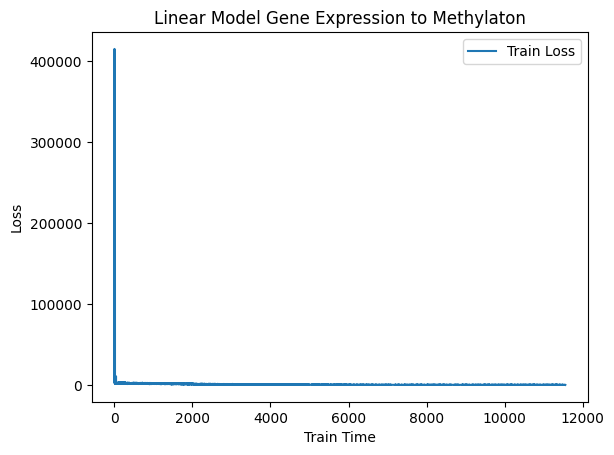

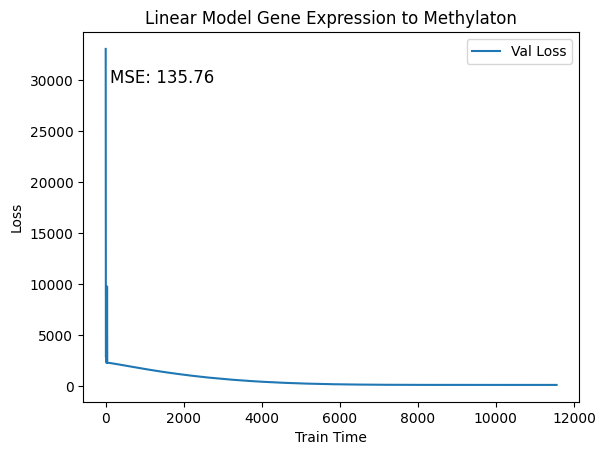

In [22]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.title("Linear Model Gene Expression to Methylaton")

plt.xlabel('Train Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

x, val_loss = zip(*val_losses)
plt.plot(x, val_loss, label='Val Loss')
plt.title("Linear Model Gene Expression to Methylaton")
x_text = (len(x)) * 0.05
y_text = max(val_loss) * 0.9
plt.text(
    x_text,
    y_text,
    f"MSE: {last_val_loss.item():.2f}",
    fontsize=12,
)
plt.xlabel('Train Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model_scripted = torch.jit.script(model)  # Export to TorchScript
if USE_ALL_SAMPLES:
    model_scripted.save("linear_model_script.all_samples.pt")
else:
    model_scripted.save("linear_model_script.pt")

In [24]:
linear_model = torch.jit.load("linear_model_script.pt").to(device)

In [25]:
linear_model.state_dict()

OrderedDict([('0.weight',
              tensor([[-5.7393e-02, -4.6932e-04, -6.1678e-02,  ..., -1.8669e-04,
                       -5.4617e-04, -5.8850e-02],
                      [-4.6409e-02,  1.3837e-03, -4.8416e-02,  ...,  1.8897e-03,
                        7.6277e-04, -3.1390e-03],
                      [-4.3791e-02,  3.6472e-03, -4.6672e-02,  ...,  1.1026e-03,
                        2.1381e-03,  2.7344e-03],
                      ...,
                      [-5.8919e-02, -5.3869e-02, -5.8134e-02,  ..., -2.7931e-03,
                       -2.2288e-03,  1.4863e-03],
                      [-5.4663e-02,  2.2732e-03, -4.9219e-02,  ..., -1.1885e-03,
                       -1.4558e-03,  6.0575e-04],
                      [-4.3279e-02, -5.5746e-02, -4.4254e-02,  ..., -8.3684e-05,
                        4.0542e-03, -5.6045e-02]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0569, -0.0435, -0.0446, -0.0521, -0.0630, -0.0441, -0.0567, -0.0632,
                      -

In [26]:
import numpy as np
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn.metrics import mean_squared_error, r2_score

import random
ones = [i for i in range(100)]
ones_2 = [i for i in range(100)]
random.shuffle(ones_2)
pearsonr(ones, ones_2)

PearsonRResult(statistic=0.0007680768076807724, pvalue=0.9939487405091926)

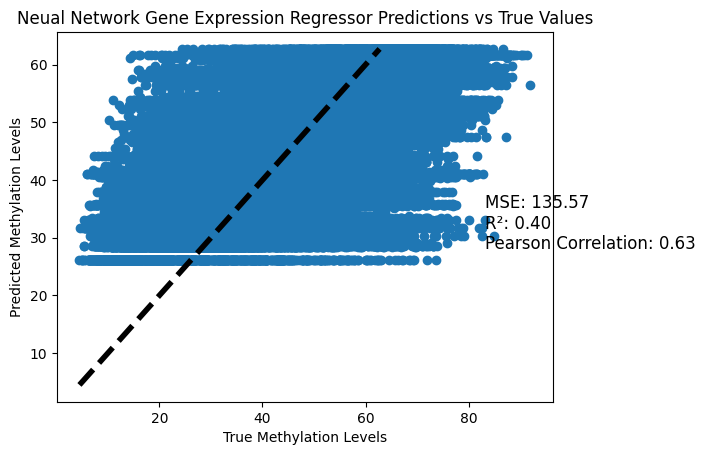

In [27]:
actual = []
predicted = []
linear_model.eval()
with torch.no_grad():
    for expression, methylation in valloader:

        expression, methylation = expression.to(device), methylation.to(device)
        pred = linear_model(expression)
        actual.extend(methylation.cpu().numpy().flatten().tolist())
        predicted.extend(pred.cpu().numpy().flatten().tolist())


pearson_corr, _ = pearsonr(actual, predicted)
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Plot the Results
plt.scatter(actual, predicted)
plt.xlabel("True Methylation Levels")
plt.ylabel("Predicted Methylation Levels")
plt.title("Neual Network Gene Expression Regressor Predictions vs True Values")
plt.plot(
    [min(actual), max(predicted)],
    [min(actual), max(predicted)],
    "k--",
    lw=4,
)

x_text = min(actual) + (max(actual) - min(actual)) * 0.9
y_text = min(predicted) + (max(predicted) - min(predicted)) * 0.05

plt.text(
    x_text,
    y_text,
    f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
    fontsize=12,
)

plt.show()